In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("Plant_data",
        shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

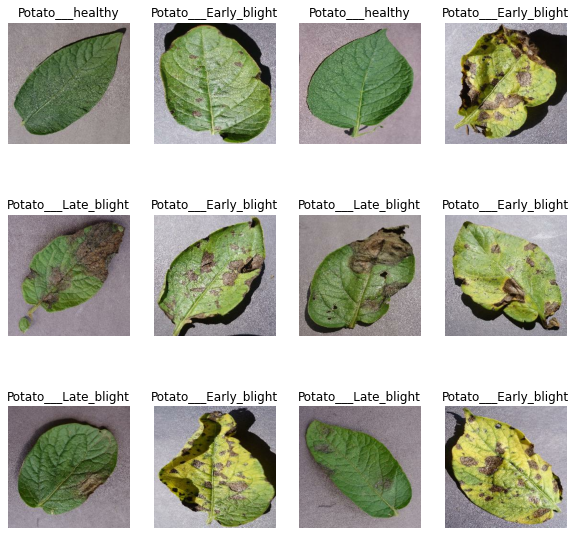

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    

In [10]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(val_ds)

6

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
n_classes=3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

NameError: name 'resize_and_rescale' is not defined

In [13]:
model.summary()

NameError: name 'model' is not defined

In [16]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history=model.fit(
   train_ds,
   epochs=EPOCHS,
   batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 99s 2s/step - loss: 0.9148 - accuracy: 0.5093 - val_loss: 0.8460 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 93s 2s/step - loss: 0.6592 - accuracy: 0.6950 - val_loss: 0.4765 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.3783 - accuracy: 0.8600 - val_loss: 0.2812 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 77s 1s/step - loss: 0.2708 - accuracy: 0.8958 - val_loss: 0.2462 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 98s 2s/step - loss: 0.2369 - accuracy: 0.9010 - val_loss: 0.3258 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 83s 2s/step - loss: 0.2085 - accuracy: 0.9155 - val_loss: 0.1675 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 78s 1s/step - loss: 0.2246 - accuracy: 0.9086 - val_loss: 0.1486 - val_accuracy: 0.9375
Epoch 8/50
54/54 [==

In [18]:
score=model.evaluate(test_ds)

8/8 [==============================] - 5s 255ms/step - loss: 0.0217 - accuracy: 0.9883


In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc=history.history['accuracy']
loss=history.history['loss']
val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

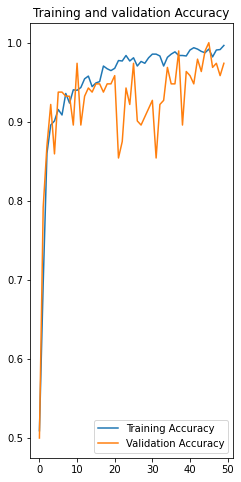

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

In [22]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [1]:
!pip install streamlit==1.11.1

  Using cached streamlit-1.11.1-py2.py3-none-any.whl (9.1 MB)

In [41]:
!pip install Pillow

In [36]:
%%writefile app.py
import streamlit as st
import tensorflow as tf


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classi fication
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (256,256)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Overwriting app.py


In [25]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=79c05f75b3e572673870b661b62b7301da983b0c76868d7f1a6f49480f03ff27
  Stored in directory: c:\users\acer nitro\appdata\local\pip\cache\wheels\f6\89\59\49d4249e00957e94813ac136a335d10ed2e09a856c5096f95c
Successfully built pyngrok


In [28]:
!ngrok authtoken 2Js7o9DbmGHgwvRAg5KpiK2T7rO_2LeoCKpqUAjB3S83j33Hh

Authtoken saved to configuration file: C:\Users\acer nitro/.ngrok2/ngrok.yml


In [31]:
get_ipython().system_raw('./ngrok http 8501 &')

In [33]:
!streamlit run app.py

^C


In [42]:
!pip list


Package                            Version
---------------------------------- --------------------
absl-py                            1.2.0
alabaster                          0.7.12
altair                             4.2.0
anaconda-client                    1.9.0
anaconda-navigator                 2.1.1
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
Babel                              2.9.1
backcall                           0.2.0
backports.functools-lru-cache      

In [43]:
!pip python

ERROR: unknown command "python"

